### Recommender system: Day in the city

In [543]:
!pip install kmodes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances, calinski_harabaz_score
from sklearn.neighbors import DistanceMetric
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
import ast
import requests
import time
%matplotlib inline

### 2. EDA -  business.json

In [4]:
# reading in file
df = pd.read_json('business.json', lines = True) 
df.describe()

,is_open,latitude,longitude,review_count,stars
count,192609.000000,192609.000000,192609.000000,192609.000000,192609.000000
mean,0.823040,38.541803,-97.594785,33.538962,3.585627
std,0.381635,4.941964,16.697725,110.135224,1.018458
min,0.000000,33.204642,-115.493471,3.000000,1.000000
25%,1.000000,33.637408,-112.274677,4.000000,3.000000
50%,1.000000,36.144815,-111.759323,9.000000,3.500000
75%,1.000000,43.602989,-79.983614,25.000000,4.500000
max,1.000000,51.299943,-72.911982,8348.000000,5.000000


In [5]:
# Dropping Canadian cities

df.postal_code = df.postal_code.apply(lambda x: x if len(x) == 5 else np.nan)

In [6]:
# Dropping Null Attributes column
df = df[~df['postal_code'].isnull()]  
df = df[~df['attributes'].isnull()]    

In [7]:
# Limiting low frequency cities to 500. Below is the list of cities to keep

keep_city = list(pd.DataFrame(df.groupby('city').filter(lambda x : len(x)>500)['city'].value_counts()).reset_index()['index'])
print('Cities to keep:', keep_city)
df.drop(df[~df.city.isin(keep_city)].index, inplace=True)

df.drop(df[df.is_open == 0].index, inplace = True) # dropping permanently closed businesses
df.drop(['is_open'], axis = 1, inplace = True) # dropping because are all open
df.head()


Cities to keep: ['Las Vegas', 'Phoenix', 'Charlotte', 'Scottsdale', 'Pittsburgh', 'Mesa', 'Henderson', 'Tempe', 'Chandler', 'Madison', 'Cleveland', 'Glendale', 'Gilbert', 'Peoria', 'North Las Vegas', 'Champaign', 'Surprise', 'Concord', 'Goodyear', 'Matthews', 'Avondale', 'Huntersville', 'Fort Mill']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC
7,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",36.099872,-115.074574,Supercuts,89121,3,3.5,NV
11,2450 E Indian School Rd,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,"{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",33.495194,-112.028588,Taco Bell,85016,18,3.0,AZ
16,"4848 E Cactus Rd, Ste 100","{'BusinessAcceptsCreditCards': 'True', 'Busine...",giC3pVVFxCRR89rApqklyw,"Hair Stylists, Beauty & Spas, Hair Salons, Men...",Scottsdale,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '...",33.600071,-111.977371,Knot Salon,85254,5,5.0,AZ


In [161]:
df.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars',
       'state', 'parents'],
      dtype='object')

Distance between businesses

In [ ]:
!pip install geopy

In [199]:


df_location = df[['business_id','name','city','address','state','latitude','longitude']]
df_location = df_location.reset_index()

df_location['lat_long'] = "(" + df_location['latitude'].map(str) + ',' + df_location['longitude'].map(str) + ")"


In [202]:
ast.literal_eval("(-1,-1)")

(-1, -1)

In [210]:
df_location.longitude.isna().sum()

0

In [211]:
df_location['lat_long'].isna().sum()

0

In [212]:
df_location['lat_long'] = df_location['lat_long'].apply(ast.literal_eval)

In [223]:
for al in df_location['lat_long']:
    if len(al) ==2:
        print(al)
        break

(40.4961769456, -80.2460112364)


In [226]:
df_test = df_location.copy()
for num, val in enumerate(df_location.lat_long):
    ls = []
    for b in df_location.lat_long:
        ls.append(great_circle(val, b).miles)
    df_test[f"distance_{num}"] = ls
        
df_test

,index,business_id,name,city,address,state,latitude,longitude,lat_long,distance_0,...,distance_5753,distance_5754,distance_5755,distance_5756,distance_5757,distance_5758,distance_5759,distance_5760,distance_5761,distance_5762
0,9,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,"Center Core - Food Court, Fl 3, Pittsburgh Int...",PA,40.496177,-80.246011,"(40.4961769456, -80.2460112364)",0.000000,...,1818.125590,1906.441765,1816.225259,1800.053942,1907.003352,1906.050079,1904.329920,1791.217617,502.687067,350.710366
1,11,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,6055 E Lake Mead Blvd,NV,36.195615,-115.040529,"(36.1956146, -115.0405289)",1896.218531,...,240.114433,14.167176,239.065662,271.231617,15.197573,9.907874,12.504023,267.904374,1439.165847,1905.454014
2,32,v-scZMU6jhnmV955RSzGJw,No. 1 Sushi Sushi,Pittsburgh,436 Market St,PA,40.441062,-80.002126,"(40.441062, -80.002126)",13.373132,...,1830.581721,1919.394789,1828.685916,1812.433351,1919.992747,1919.018514,1917.283467,1803.615640,515.954697,348.460720
3,35,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,"13843 N Tatum Blvd, Ste 15",AZ,33.613020,-111.977036,"(33.6130201898, -111.9770356779)",1802.405549,...,16.306665,244.780139,15.050686,22.813172,263.278912,252.198811,244.040899,19.701061,1382.067744,1768.216828
4,69,nsNONDHbV7Vudqh21uicqw,Salt Cellar,Scottsdale,550 N Hayden Rd,AZ,33.454286,-111.909405,"(33.454286, -111.909405)",1803.452266,...,21.690402,255.211975,21.742993,11.621413,273.880670,262.716591,254.513915,13.092982,1385.178412,1766.910632
5,73,6fPQJq4f_yiq1NHn0fd11Q,La Creperie,Las Vegas,3655 Las Vegas Blvd S,NV,36.112527,-115.171351,"(36.1125266402, -115.1713514328)",1905.028469,...,240.896172,7.031081,239.935982,272.342636,13.814109,1.992726,6.633557,269.371585,1448.282481,1913.544173
6,75,k-dDZvTeLysoJvjHI-qr9g,Feast Buffet,Las Vegas,2411 W Sahara Ave,NV,36.142116,-115.174252,"(36.1421161808, -115.1742515629)",1904.487475,...,242.479196,9.078388,241.506421,273.880990,11.958927,1.585416,8.575118,270.856310,1447.489389,1913.388952
7,79,MhnihE0alud0ereVInSt8Q,Yummy Yummy Chinese Restaurant,Scottsdale,"2765 N Scottsdale Rd, Ste 105",AZ,33.478754,-111.925484,"(33.478754, -111.925484)",1803.583073,...,20.216619,253.364453,20.131161,13.504894,272.016008,260.860282,252.662080,14.007240,1384.960384,1767.425534
8,93,OwXMxqxIy4YoprAjnoUoiA,B & M Bar-B-Que Shaw,Cleveland,12700 Shaw Ave,OH,41.540890,-81.595327,"(41.5408904, -81.59532659999999)",100.785192,...,1756.504204,1835.379290,1754.530375,1739.717537,1835.129433,1834.647579,1833.257700,1730.587993,411.310538,423.118702
9,113,c7JoAt6a3Ufkpn3TrGU23A,Santanas Mexican Food,Phoenix,1930 W Buckeye Rd,AZ,33.436984,-112.101267,"(33.436984, -112.1012667)",1813.990800,...,13.106666,248.336502,14.241637,20.261504,267.288114,255.982103,247.709185,24.214814,1394.905746,1777.950292


Cleaning Features

In [8]:
# Categories df

cat = pd.read_json('categories.json')

In [9]:
cat.head(2)

,alias,country_blacklist,country_whitelist,parents,title
0,3dprinting,NaN,NaN,[localservices],3D Printing
1,abruzzese,NaN,[IT],[italian],Abruzzese


In [10]:
df.categories = df.categories.apply(lambda x: x.replace(" ",""))

In [11]:
df.categories = df.categories.str.split(",")

In [12]:
df = df.reset_index().drop(['index'],axis = 1)

In [13]:
ls = []
for i in range(df.shape[0]):
    if df.categories[i] == None:
        ls.append(np.nan)
    else:
        x = str(cat.parents[cat.title == df.categories[i][0]])
        ls.append(x[x.index("[")+1:x.index("]")])
df["parents"] = ls

In [14]:
# Restaurants only
df_non_restaurants = df.drop(df[df.parents == 'restaurants'].index)
df = df.drop(df[df.parents != 'restaurants'].index)
df.head()

,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,review_count,stars,state,parents
9,"Center Core - Food Court, Fl 3, Pittsburgh Int...","{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1RHY4K3BD22FK7Cfftn8Mg,"[Sandwiches, Salad, Restaurants, Burgers, Comf...",Pittsburgh,None,40.496177,-80.246011,Marathon Diner,15231,35,4.0,PA,restaurants
11,6055 E Lake Mead Blvd,"{'BikeParking': 'True', 'BusinessParking': '{'...",tstimHoMcYbkSC4eBA1wEg,"[Mexican, Restaurants, Patisserie/CakeShop, Fo...",Las Vegas,"{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'...",36.195615,-115.040529,Maria's Mexican Restaurant & Bakery,89156,184,4.5,NV,restaurants
32,436 Market St,"{'OutdoorSeating': 'False', 'HasTV': 'True', '...",v-scZMU6jhnmV955RSzGJw,"[Japanese, SushiBars, Restaurants]",Pittsburgh,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",40.441062,-80.002126,No. 1 Sushi Sushi,15222,106,4.5,PA,restaurants
35,"13843 N Tatum Blvd, Ste 15","{'Caters': 'True', 'GoodForKids': 'True', 'Noi...",44YFU284Z3KDEy25QyVoUw,"[Chinese, Restaurants]",Phoenix,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",33.613020,-111.977036,Nee House Chinese Restaurant,85032,269,3.5,AZ,restaurants
69,550 N Hayden Rd,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",nsNONDHbV7Vudqh21uicqw,"[Seafood, Restaurants]",Scottsdale,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",33.454286,-111.909405,Salt Cellar,85257,526,3.5,AZ,restaurants


In [15]:
# Converting Attributes dictionary in dataframe

attributes_df = df.attributes.apply(pd.Series)
attributes_df = pd.concat([df, attributes_df], axis = 1)

#Dropping non-attribute columns
attributes_df = attributes_df.drop(['address', 'attributes','hours',
                                    'latitude', 'longitude', 'name', 'postal_code'], axis = 1)

In [16]:
#Cleaning Noise Level

ch = {"u'average'": "'average'","u'quiet'": "'quiet'","u'loud'": "'loud'","u'very_loud'": "'very_loud'"}
attributes_df.NoiseLevel = attributes_df.NoiseLevel.replace(to_replace = ch, value=None)

In [17]:
attributes_df.RestaurantsPriceRange2.value_counts()

1       2843
2       2430
3        154
4         34
None       4
Name: RestaurantsPriceRange2, dtype: int64

In [18]:
attributes_df[(attributes_df.review_count > 50) & (attributes_df.GoodForMeal.isnull() == True)].business_id.count()

145

In [19]:
attributes_df = attributes_df[attributes_df.GoodForMeal.isnull() == False]

In [20]:
attributes_df = attributes_df.reset_index().drop(['index'], axis = 1)

In [21]:
goodformeal_df = attributes_df.GoodForMeal.apply(ast.literal_eval)
goodformeal_df = goodformeal_df.apply(pd.Series)
goodformeal_df.head(2)

,dessert,latenight,lunch,dinner,brunch,breakfast
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0


In [22]:
attributes_df = pd.concat([attributes_df, goodformeal_df], axis = 1)

In [23]:
cat_df = attributes_df.categories.apply(lambda x: dict(zip(x, [True]*len(x)))).apply(pd.Series)

In [24]:
attributes_df = pd.concat([attributes_df, cat_df], axis = 1)

In [25]:
attributes_df.shape

(4440, 319)

In [26]:
#Categories to drop : low frequency < 5

cat_drop = []
for col in cat_df.columns:
    if cat_df[col].count() <=5:
        cat_drop.append(col)
len(cat_drop)

137

In [27]:
# Dropping from attributes df low frequency columns

for col in cat_drop:
    attributes_df.drop([col],axis =1, inplace=True)

In [28]:
attributes_df.shape

(4440, 182)

In [29]:
attributes_df = attributes_df[attributes_df.RestaurantsPriceRange2 != 'None']
attributes_df.drop(['categories'],axis = 1)

,business_id,city,review_count,stars,state,parents,RestaurantsTakeOut,BusinessParking,Ambience,RestaurantsDelivery,...,Kebab,HealthMarkets,HotPot,MusicVenues,Kosher,Live/RawFood,Afghan,African,Persian/Iranian,Smokehouse
0,1RHY4K3BD22FK7Cfftn8Mg,Pittsburgh,35,4.0,PA,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tstimHoMcYbkSC4eBA1wEg,Las Vegas,184,4.5,NV,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v-scZMU6jhnmV955RSzGJw,Pittsburgh,106,4.5,PA,restaurants,True,"{'garage': False, 'street': True, 'validated':...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44YFU284Z3KDEy25QyVoUw,Phoenix,269,3.5,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nsNONDHbV7Vudqh21uicqw,Scottsdale,526,3.5,AZ,restaurants,False,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6fPQJq4f_yiq1NHn0fd11Q,Las Vegas,535,3.5,NV,restaurants,True,"{'garage': True, 'street': False, 'validated':...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,k-dDZvTeLysoJvjHI-qr9g,Las Vegas,287,3.0,NV,restaurants,False,"{'garage': True, 'street': False, 'validated':...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,F6c3D1o9Z4Tl6cDorb3WgA,Pittsburgh,75,3.5,PA,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'classy...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,hXzoNgpkC86K_Jfg_zMHvA,Glendale,96,4.5,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'touristy': False, 'hipster': False, 'romanti...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AMN3Sgns9tB2x-b3eWk0qQ,Scottsdale,457,4.0,AZ,restaurants,True,"{'garage': False, 'street': False, 'validated'...","{'romantic': False, 'intimate': False, 'touris...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
clean_df = attributes_df.drop(['categories','city','state','parents','RestaurantsTakeOut',
                   'RestaurantsDelivery','DriveThru','GoodForMeal','WiFi',
                   'Caters','RestaurantsTableService','BYOBCorkage','Corkage',
                   'BYOB','CoatCheck','Smoking','GoodForDancing','DogsAllowed',
                   'BusinessAcceptsBitcoin','ByAppointmentOnly','AgesAllowed',
                   'Open24Hours','DietaryRestrictions','RestaurantsCounterService',
                   'AcceptsInsurance','Music','BestNights', 'HappyHour'],axis = 1)

In [32]:
# Number of Ambience null values to drop
sum(clean_df.Ambience.isnull())

116

In [33]:
# Unpacking Ambience dictionary & dropping null values

clean_df = clean_df[clean_df.Ambience.isnull() == False]
ambience_df = clean_df.Ambience.apply(ast.literal_eval)
ambience_df = ambience_df.apply(pd.Series)
clean_df = pd.concat([clean_df, ambience_df], axis = 1)
clean_df.drop(['Ambience'],axis = 1,inplace = True)
clean_df.head(2)

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,"{'garage': False, 'street': False, 'validated'...",False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,"{'garage': False, 'street': False, 'validated'...",False,True,1,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
clean_df[clean_df.BusinessParking.isnull() == True]

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
30,iE71iwcSljg3xm2GB2Y9aA,497,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,lqPuSiWypNCACEMhArSZ2A,22,2.5,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,gPZj-XXVwFHgd8zjJPzVCw,12,3.5,NaN,False,True,1,True,True,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,QzvLnOqwH6BIY_jCOvzuQQ,30,2.5,NaN,False,True,2,False,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,xVWLSFGNr4w4DYvYiafMPw,10,4.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,9q8phddM1YWNKZVepKi6iQ,10,3.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,8CjI8nebSDB5aINJc3dLwA,13,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Kzo1z1hW6224lNd3al2SbQ,29,3.5,NaN,False,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,oNCF7oHyKYlGLu_kHV2MSg,9,2.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,MYB1ZMspBk1Xc_awp_PtSw,79,3.5,NaN,False,True,2,True,False,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
clean_df[clean_df.BusinessParking.isnull() == True]

,business_id,review_count,stars,BusinessParking,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,...,Smokehouse,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual
30,iE71iwcSljg3xm2GB2Y9aA,497,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,lqPuSiWypNCACEMhArSZ2A,22,2.5,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,gPZj-XXVwFHgd8zjJPzVCw,12,3.5,NaN,False,True,1,True,True,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,QzvLnOqwH6BIY_jCOvzuQQ,30,2.5,NaN,False,True,2,False,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158,xVWLSFGNr4w4DYvYiafMPw,10,4.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,9q8phddM1YWNKZVepKi6iQ,10,3.0,NaN,False,True,1,True,True,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189,8CjI8nebSDB5aINJc3dLwA,13,4.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,Kzo1z1hW6224lNd3al2SbQ,29,3.5,NaN,False,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
236,oNCF7oHyKYlGLu_kHV2MSg,9,2.0,NaN,True,True,2,True,True,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,MYB1ZMspBk1Xc_awp_PtSw,79,3.5,NaN,False,True,2,True,False,True,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Unpacking Parking column - replacing null values by no street parking

parking_df = clean_df.BusinessParking.replace(to_replace = np.nan, value = "{'street':False}")
parking_df = parking_df.apply(ast.literal_eval)
parking_df = parking_df.apply(pd.Series)

In [37]:
# Assigning Boolean value to parking: True if garage, validated, lot, valet parking available; False otherwise.

parking_df['parking'] = parking_df['garage']|parking_df['validated']|parking_df['lot']|parking_df['valet']
parking_df.drop(['garage','street','validated','lot','valet'], axis = 1, inplace=True)
clean_df = pd.concat([clean_df, parking_df], axis = 1)
clean_df.drop(['BusinessParking'],axis = 1,inplace = True)

In [38]:
#Cleaning Restaurants Attire

attire = {"u'casual'": "'casual'","u'dressy'": "'dressy'","u'formal'":"'dressy'","'formal'":"'dressy'"}
clean_df.RestaurantsAttire = clean_df.RestaurantsAttire.replace(to_replace = attire, value=None)

In [39]:
#Cleaning Alcohol

alc = {"u'none'": "False","'none'": "False","None": "False","u'full_bar'": "True","'full_bar'": "True",
      "u'beer_and_wine'": "True","'beer_and_wine'":"True"}
clean_df.Alcohol = clean_df.Alcohol.replace(to_replace = alc, value=None)

In [40]:
clean_df.WheelchairAccessible.value_counts()

True     954
False     52
None       4
Name: WheelchairAccessible, dtype: int64

In [41]:
clean_df.head(3)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,touristy,hipster,romantic,divey,intimate,trendy,upscale,classy,casual,parking
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,False,True,1,True,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,False,True,1,True,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True
2,v-scZMU6jhnmV955RSzGJw,106,4.5,False,True,2,False,True,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False


In [42]:
# Filling NA values

clean_df.RestaurantsPriceRange2.fillna(1, inplace = True)
clean_df.RestaurantsPriceRange2.isna().sum()

0

In [43]:
clean_df.RestaurantsAttire.value_counts()

'casual'    4121
'dressy'      91
Name: RestaurantsAttire, dtype: int64

In [44]:


wch = {False:0, True:1,'False':0, 'True':1,'None':0}
clean_df.WheelchairAccessible = clean_df.WheelchairAccessible.replace(to_replace = wch, value=None)
clean_df.GoodForKids = clean_df.GoodForKids.replace(to_replace = wch, value=None)
clean_df.HasTV = clean_df.HasTV.replace(to_replace = wch, value=None)
clean_df.OutdoorSeating = clean_df.OutdoorSeating.replace(to_replace = wch, value=None)
clean_df.BikeParking = clean_df.BikeParking.replace(to_replace = wch, value=None)
clean_df.Alcohol = clean_df.Alcohol.replace(to_replace = wch, value=None)
clean_df.BusinessAcceptsCreditCards = clean_df.BusinessAcceptsCreditCards.replace(to_replace = wch, value=None)
clean_df.RestaurantsReservations = clean_df.RestaurantsReservations.replace(to_replace = wch, value=None)
clean_df.RestaurantsGoodForGroups = clean_df.RestaurantsGoodForGroups.replace(to_replace = wch, value=None)

clean_df.RestaurantsAttire.fillna("'casual'", inplace = True)  

clean_df.NoiseLevel = clean_df.NoiseLevel.replace('None', value="'average'")
clean_df.NoiseLevel.fillna("'average'", inplace = True)  

clean_df.WheelchairAccessible.fillna(2, inplace = True)  # 2 means unknown
clean_df.fillna(0, inplace=True)
clean_df = clean_df.replace(to_replace = wch, value=None)

In [45]:
# change type
clean_df.RestaurantsPriceRange2 = clean_df.RestaurantsPriceRange2.astype(int)

In [46]:
clean_df = pd.concat([clean_df,pd.get_dummies(clean_df.NoiseLevel),pd.get_dummies(clean_df.RestaurantsAttire)],
                     axis = 1)
clean_df.drop(['NoiseLevel','RestaurantsAttire'], axis = 1, inplace = True)

In [47]:
clean_df.head(2)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,upscale,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy'
0,1RHY4K3BD22FK7Cfftn8Mg,35,4.0,0.0,1.0,1,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,0
1,tstimHoMcYbkSC4eBA1wEg,184,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1,1,0,0,0,1,0


In [257]:
clean_df = clean_df.reset_index()

In [260]:
clean_df.drop(['index'],axis = 1, inplace= True)

### Part 2: Modeling

In [261]:
X = clean_df.drop(['business_id'], axis = 1)

In [262]:
X.shape

(4322, 165)

#### Part 2 A: Clustering

In [51]:

k_means = KMeans(n_clusters=10) # Must set number of clusters at initialization time!
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [52]:
preds = k_means.predict(X)

In [53]:
centers = k_means.cluster_centers_

In [54]:
pd.DataFrame(k_means.cluster_centers_, columns = X.columns)

,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,BikeParking,...,upscale,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy'
0,128.609319,3.692652,0.353047,0.984767,1.606631,0.931900,0.914875,0.613799,0.448029,0.815412,...,0.022401,0.030466,0.896953,0.734767,0.790323,0.033154,1.729391e-01,3.584229e-03,0.978495,0.021505
1,1610.800000,4.133333,0.533333,1.000000,2.166667,0.966667,0.766667,0.566667,0.400000,0.633333,...,0.066667,0.066667,0.766667,0.766667,0.933333,0.033333,-5.551115e-17,3.333333e-02,0.900000,0.100000
2,410.841360,3.876771,0.521246,0.994334,1.881020,0.960340,0.849858,0.682720,0.566572,0.847025,...,0.025496,0.048159,0.855524,0.841360,0.937677,0.011331,5.099150e-02,1.734723e-18,0.963173,0.036827
3,3676.800000,4.100000,0.600000,1.000000,2.200000,0.800000,0.600000,0.600000,0.200000,0.400000,...,0.200000,0.200000,0.600000,1.000000,0.800000,0.200000,0.000000e+00,0.000000e+00,0.800000,0.200000
4,42.161847,3.362253,0.168442,0.975647,1.363267,0.859462,0.927955,0.435312,0.321157,0.664637,...,0.003551,0.009132,0.544901,0.469812,0.723998,0.060375,1.922882e-01,2.333841e-02,0.993404,0.006596
5,1007.037975,4.025316,0.620253,0.987342,2.063291,0.974684,0.759494,0.632911,0.582278,0.683544,...,0.101266,0.113924,0.670886,0.898734,0.886076,0.088608,1.265823e-02,1.265823e-02,0.873418,0.126582
6,2495.333333,3.944444,0.444444,1.000000,2.111111,0.777778,0.666667,0.555556,0.333333,0.444444,...,0.000000,0.111111,0.777778,0.777778,0.888889,0.111111,0.000000e+00,0.000000e+00,0.777778,0.222222
7,6708.000000,3.500000,0.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000
8,247.816832,3.819307,0.480198,0.990099,1.777228,0.955446,0.892739,0.641914,0.544554,0.851485,...,0.011551,0.041254,0.892739,0.803630,0.866337,0.016502,1.171617e-01,1.752071e-16,0.975248,0.024752
9,632.914474,3.963816,0.572368,0.980263,1.980263,0.986842,0.776316,0.657895,0.480263,0.723684,...,0.065789,0.092105,0.776316,0.894737,0.960526,0.026316,1.315789e-02,-2.255141e-17,0.934211,0.065789


Optimal number of clusters

In [55]:
k_means_4 = KMeans(n_clusters=4).fit(X)
k_means_7 = KMeans(n_clusters=7).fit(X)
k_means_10 = KMeans(n_clusters=10).fit(X)
k_means_13 = KMeans(n_clusters=13).fit(X)
k_means_16 = KMeans(n_clusters=16).fit(X)
k_means_19 = KMeans(n_clusters=19).fit(X)
k_means_22 = KMeans(n_clusters=22).fit(X)
k_means_25 = KMeans(n_clusters=100).fit(X)

k_list = [k_means_4,k_means_7,k_means_10,k_means_13,k_means_16,k_means_19,k_means_22,k_means_25]

In [56]:
CH_score = []
for ls in k_list:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))

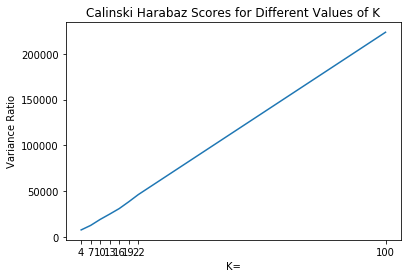

In [57]:
plt.plot([4,7,10,13,16,19,22,100], CH_score)
plt.xticks([4,7,10,13,16,19,22,100])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

In [71]:
# Testing different number of clusters to find 

k_means_16 = KMeans(n_clusters=16).fit(X)
k_means_19 = KMeans(n_clusters=19).fit(X)
k_means_22 = KMeans(n_clusters=22).fit(X)
k_means_25 = KMeans(n_clusters=25).fit(X)
k_means_30 = KMeans(n_clusters=30).fit(X)

k_means_5 = KMeans(n_clusters=5).fit(X)
k_means_50 = KMeans(n_clusters=50).fit(X)
k_means_100 = KMeans(n_clusters=100).fit(X)
k_means_150 = KMeans(n_clusters=150).fit(X)
k_means_200 = KMeans(n_clusters=200).fit(X)
k_means_120 = KMeans(n_clusters=120).fit(X)
k_means_130 = KMeans(n_clusters=130).fit(X)
k_means_140 = KMeans(n_clusters=140).fit(X)
k_means_150 = KMeans(n_clusters=150).fit(X)
k_means_160 = KMeans(n_clusters=160).fit(X)
k_means_170 = KMeans(n_clusters=170).fit(X)
k_means_180 = KMeans(n_clusters=180).fit(X)
k_means_190 = KMeans(n_clusters=190).fit(X)


k_list = [k_means_16,k_means_19,k_means_22,k_means_25,k_means_30]


CH_score = []
for ls in k_list:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))


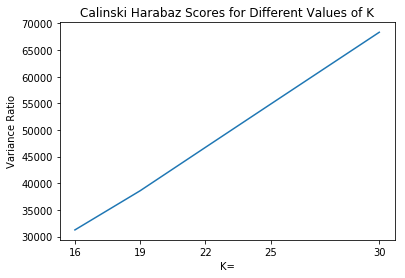

In [72]:
plt.plot([16,19,22,25,30], CH_score)
plt.xticks([16,19,22,25,30])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

In [73]:
k_list2 = [k_means_120, 
k_means_130 ,
k_means_140 ,
k_means_150 ,
k_means_160 ,
k_means_170 ,
k_means_180 ,
k_means_190 ]

CH_score = []
for ls in k_list2:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))

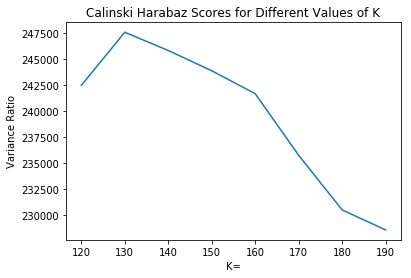

In [74]:
plt.plot([120,130,140,150,160,170,180,190], CH_score)
plt.xticks([120,130,140,150,160,170,180,190])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

In [75]:
k_means_130 = KMeans(n_clusters=130, init= 'random').fit_predict(X)

In [76]:
X_and_Y = pd.concat([X, pd.Series(k_means_130)],axis = 1)
X_and_Y.rename(columns={0:'pred'}, inplace=True)

In [78]:
# Added init parameter

k_means_5 = KMeans(n_clusters=5, init = 'random').fit(X)
k_means_50 = KMeans(n_clusters=50, init = 'random').fit(X)
k_means_100 = KMeans(n_clusters=100, init = 'random').fit(X)
k_means_150 = KMeans(n_clusters=150, init = 'random').fit(X)
k_means_200 = KMeans(n_clusters=200, init = 'random').fit(X)
k_means_120 = KMeans(n_clusters=120, init = 'random').fit(X)
k_means_130 = KMeans(n_clusters=130, init = 'random').fit(X)
k_means_140 = KMeans(n_clusters=140, init = 'random').fit(X)
k_means_150 = KMeans(n_clusters=150, init = 'random').fit(X)
k_means_160 = KMeans(n_clusters=160, init = 'random').fit(X)
k_means_170 = KMeans(n_clusters=170, init = 'random').fit(X)
k_means_180 = KMeans(n_clusters=180, init = 'random').fit(X)
k_means_190 = KMeans(n_clusters=190, init = 'random').fit(X)

k_list2 = [k_means_120, 
k_means_130 ,
k_means_140 ,
k_means_150 ,
k_means_160 ,
k_means_170 ,
k_means_180 ,
k_means_190 ]

CH_score = []
for ls in k_list2:
    labels = ls.labels_
    CH_score.append(calinski_harabaz_score(X,labels))

Calinski Harabaz Score : The higher VRC values point out the most appropriate number of clusters; it appraises both the distance between different clusters, as well as the closeness of data within each of those clusters (Cali´nskiCali´nski and Harabasz, 1974)

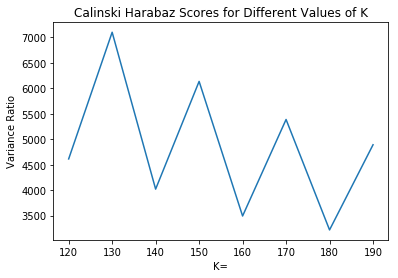

In [80]:
plt.plot([120,130,140,150,160,170,180,190], CH_score)
plt.xticks([120,130,140,150,160,170,180,190])
plt.title("Calinski Harabaz Scores for Different Values of K")
plt.ylabel("Variance Ratio")
plt.xlabel("K=")
plt.show()

Agglomerative clustering

In [81]:
def agg_cluster(X, n_list):
    klist = []
    preds_list = []
    for n in n_list:
        agg = AgglomerativeClustering(n_clusters = n, affinity= 'euclidean', linkage = 'ward')
        preds_list.append(agg.fit_predict(X))
        klist.append(agg.fit(X))
    return klist, preds_list

In [82]:
k_list, agg_preds= agg_cluster(X, [5,10,50,100])

In [85]:
def calinski_plot(X, n_list):
    k_list, preds_list = agg_cluster(X, n_list)
    CH_score = []
    for ls in k_list:
        labels = ls.labels_
        CH_score.append(calinski_harabaz_score(X,labels))

    plt.plot(n_list, CH_score)
    plt.xticks(n_list)
    plt.title("Calinski Harabaz Scores for Different Values of K")
    plt.ylabel("Variance Ratio")
    plt.xlabel("K=")
    plt.show()

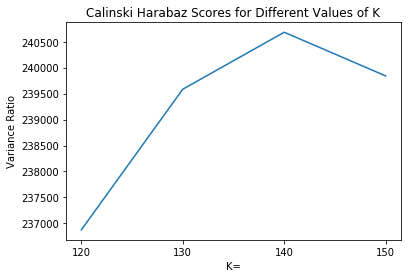

In [86]:
calinski_plot(X, [120,130, 140, 150])

In [87]:
_, preds = agg_cluster(X, [140])

In [88]:
def concat_preds(X, preds): 
    X_and_Y = pd.concat([X, pd.Series(preds[0])],axis = 1)
    X_and_Y.rename(columns={0:'pred'}, inplace=True)
    return X_and_Y

In [89]:
X_and_Y = concat_preds(X, preds)

In [90]:
X_and_Y.head()

,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,BikeParking,...,classy,casual,parking,'average','loud','quiet','very_loud','casual','dressy',pred
0,35.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,47.0
1,184.0,4.5,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,12.0
2,106.0,4.5,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0
3,269.0,3.5,1.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0
4,526.0,3.5,1.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,74.0


In [91]:
#Gaussian Mixture 

gmm = GaussianMixture(n_components=100)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=100, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [92]:
gmm_preds = gmm.predict(X)

In [93]:
gmm_preds

array([ 0, 30, 94, ..., 36, 92,  5])

In [95]:
def calinski_plot(X, n_list):
    
    CH_score = []
    
    for n in n_list:
        gmm = GaussianMixture(n_components = n)
        gmm_preds = gmm.fit_predict(X)
        CH_score.append(calinski_harabaz_score(X,gmm_preds))

    plt.plot(n_list, CH_score)
    plt.xticks(n_list)
    plt.title("Calinski Harabaz Scores for Different Values of Components")
    plt.ylabel("Variance Ratio")
    plt.xlabel("Number of components=")
    plt.show()

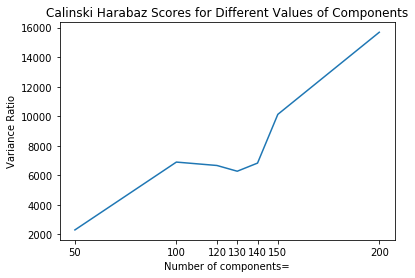

In [97]:
calinski_plot(X, [50,100,120,130,140,150,200])

In [227]:
silhouette_score(X, gmm_preds, metric= '')

ValueError: Unknown metric . Valid metrics are ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski'], or 'precomputed', or a callable

In [264]:
similarity_matrix = pd.DataFrame(pairwise_distances(X, metric='cosine'), columns=clean_df.iloc[:,0])
similarity_matrix.head(2)

business_id,1RHY4K3BD22FK7Cfftn8Mg,tstimHoMcYbkSC4eBA1wEg,v-scZMU6jhnmV955RSzGJw,44YFU284Z3KDEy25QyVoUw,nsNONDHbV7Vudqh21uicqw,6fPQJq4f_yiq1NHn0fd11Q,k-dDZvTeLysoJvjHI-qr9g,F6c3D1o9Z4Tl6cDorb3WgA,hXzoNgpkC86K_Jfg_zMHvA,AMN3Sgns9tB2x-b3eWk0qQ,...,KOEBBp2PhiV_4PkW9eo9Sg,kOo4ZY2UQAX4j312mzQ8mA,epR6riXzEtGRmao3gB6yiw,jJZwQj3Pwv1OMZ8bQpKxnw,Lhl72icGvaW2rFClTy-hog,qRymrsLmlA34bC8PvNoujg,P8uECqGqXWTwEndkh-6bQw,p5rpYtxS5xPQjt3MXYVEwA,I3dQmMkfqMsThMAuqIkooA,JsRt9LPgv-7guVcY4u6OQA
0,0.000000,0.008589,0.006831,0.009925,0.011088,0.011104,0.010503,0.004733,0.006062,0.010779,...,0.011046,0.006746,0.009180,0.004523,0.007481,0.011102,0.011106,0.011265,0.008398,0.007868
1,0.008589,0.000000,0.000531,0.000179,0.000361,0.000369,0.000255,0.001255,0.000752,0.000286,...,0.000335,0.010077,0.011976,0.010835,0.000416,0.000347,0.000363,0.000388,0.000220,0.000297


In [265]:
similarity_matrix.shape

(4322, 4322)

In [266]:
df_similarity = pd.concat([clean_df.iloc[:,0],similarity_matrix], axis=1)

https://datascience.stackexchange.com/questions/8681/clustering-for-mixed-numeric-and-nominal-discrete-data

In [ ]:
similarity_matrix.iloc[0].sort_values()

In [ ]:
X_and_Y[X_and_Y.pred == 47.0]

In [ ]:
sorted(list(similarity_matrix.iloc[0]))[1:11]

In [ ]:
def gower_distance(X):
    individual_variable_distances = []
    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

### K-Means, K-Modes combination -> K-Prototype Algorithm

In [143]:
kmode = KModes(n_clusters = 100, verbose = 2)
clustered_modes = kmode.fit_predict(X.iloc[:,1:])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2696, cost: 23677.0
Run 1, iteration: 2/100, moves: 994, cost: 23163.0
Run 1, iteration: 3/100, moves: 385, cost: 23020.0
Run 1, iteration: 4/100, moves: 68, cost: 23020.0


In [145]:
clustered_modes

array([64,  0, 54, ..., 15, 34, 29], dtype=uint16)

### K-means & K-Mode combination -> K-Prototype algorithm



> The k-means algorithm is well known for its efficiency in clustering large data sets. However, working only on numeric values prohibits it from being used to cluster real world data containing categorical values.

In this paper we present two algorithms which extend the k-means algorithm to categorical domains and domains with mixed numeric and categorical values.

The k-modes algorithm uses a simple matching dissimilarity measure to deal with categorical objects, replaces the means of clusters with modes, and uses a frequency-based method to update modes in the clustering process to minimise the clustering cost function.

With these extensions, the k-modes algorithm enables the clustering of categorical data in a fashion similar to k-means.

The k-prototypes algorithm, through the definition of a combined dissimilarity measure, further integrates the k-means and k-modes algorithms to allow for clustering objects described by mixed numeric and categorical attributes. 

In [155]:
kproto = KPrototypes(n_clusters=2, init = 'cao', verbose=2)
clusters = kproto.fit_predict(X, categorical= list(range(2,165)))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1980, ncost: 234533085.00504956
Run: 1, iteration: 2/100, moves: 636, ncost: 204495923.2583549
Run: 1, iteration: 3/100, moves: 254, ncost: 192594878.00187048
Run: 1, iteration: 4/100, moves: 120, ncost: 186767560.35782808
Run: 1, iteration: 5/100, moves: 82, ncost: 182624793.9063555
Run: 1, iteration: 6/100, moves: 48, ncost: 180324389.39131215
Run: 1, iteration: 7/100, moves: 16, ncost: 179897779.0686077
Run: 1, iteration: 8/100, moves: 13, ncost: 179655131.12984934
Run: 1, iteration: 9/100, moves: 10, ncost: 179406575.02220258
Run: 1, iteration: 10/100, moves: 14, ncost: 179035173.57861412
Run: 1, iteration: 11/100, moves: 8, ncost: 178859589.8565184
Run: 1, iteration: 12/100, moves: 3, ncost: 178836330.65302786
Run: 1, iteration: 13/100, moves: 0, ncost: 178836330.65302786
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 

KeyboardInterrupt: 

In [272]:
df_test.name = df_test.name.str.lower()

In [334]:
df_test[["name", "city", "state"]] = df_test[["name", "city", "state"]].apply(lambda x: x.str.lower())

In [342]:
df_test.drop(['index'], axis=1, inplace=True)

In [355]:
df_test.iloc[:,8:].shape

(5763, 5763)

In [398]:
df_distance = df_test.iloc[:,8:]
df_distance.columns = df_test.business_id
df_distance.columns.name = None

# df_distance.index.rename('index', inplace = True)
df_distance['business_id'] = df_test.business_id

In [399]:
df_distance.head()

,1RHY4K3BD22FK7Cfftn8Mg,tstimHoMcYbkSC4eBA1wEg,v-scZMU6jhnmV955RSzGJw,44YFU284Z3KDEy25QyVoUw,nsNONDHbV7Vudqh21uicqw,6fPQJq4f_yiq1NHn0fd11Q,k-dDZvTeLysoJvjHI-qr9g,MhnihE0alud0ereVInSt8Q,OwXMxqxIy4YoprAjnoUoiA,c7JoAt6a3Ufkpn3TrGU23A,...,jJZwQj3Pwv1OMZ8bQpKxnw,Lhl72icGvaW2rFClTy-hog,MBHGhr936i0slW9Bw4XIYA,qRymrsLmlA34bC8PvNoujg,P8uECqGqXWTwEndkh-6bQw,p5rpYtxS5xPQjt3MXYVEwA,I3dQmMkfqMsThMAuqIkooA,VD358OTsTLFuxOZJTOInKQ,JsRt9LPgv-7guVcY4u6OQA,business_id
index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1896.218531,13.373132,1802.405549,1803.452266,1905.028469,1904.487475,1803.583073,100.785192,1813.990800,...,1906.441765,1816.225259,1800.053942,1907.003352,1906.050079,1904.329920,1791.217617,502.687067,350.710366,1RHY4K3BD22FK7Cfftn8Mg
1,1896.218531,0.000000,1909.189163,248.916792,259.610302,9.285653,8.324442,257.736379,1824.775165,253.205465,...,14.167176,239.065662,271.231617,15.197573,9.907874,12.504023,267.904374,1439.165847,1905.454014,tstimHoMcYbkSC4eBA1wEg
2,13.373132,1909.189163,0.000000,1814.849672,1815.863613,1917.993862,1917.456388,1815.999895,112.594892,1826.412216,...,1919.394789,1828.685916,1812.433351,1919.992747,1919.018514,1917.283467,1803.615640,515.954697,348.460720,v-scZMU6jhnmV955RSzGJw
3,1802.405549,248.916792,1814.849672,0.000000,11.638623,250.209531,251.719189,9.740319,1741.002240,14.111701,...,244.780139,15.050686,22.813172,263.278912,252.198811,244.040899,19.701061,1382.067744,1768.216828,44YFU284Z3KDEy25QyVoUw
4,1803.452266,259.610302,1815.863613,11.638623,0.000000,260.729964,262.266177,1.927939,1742.589697,11.125657,...,255.211975,21.742993,11.621413,273.880670,262.716591,254.513915,13.092982,1385.178412,1766.910632,nsNONDHbV7Vudqh21uicqw


In [400]:
df_final = df_similarity.merge(df_test[['name', 'business_id', 'city', 'state']], on='business_id')

In [401]:
df_final.head()

,business_id,1RHY4K3BD22FK7Cfftn8Mg,tstimHoMcYbkSC4eBA1wEg,v-scZMU6jhnmV955RSzGJw,44YFU284Z3KDEy25QyVoUw,nsNONDHbV7Vudqh21uicqw,6fPQJq4f_yiq1NHn0fd11Q,k-dDZvTeLysoJvjHI-qr9g,F6c3D1o9Z4Tl6cDorb3WgA,hXzoNgpkC86K_Jfg_zMHvA,...,jJZwQj3Pwv1OMZ8bQpKxnw,Lhl72icGvaW2rFClTy-hog,qRymrsLmlA34bC8PvNoujg,P8uECqGqXWTwEndkh-6bQw,p5rpYtxS5xPQjt3MXYVEwA,I3dQmMkfqMsThMAuqIkooA,JsRt9LPgv-7guVcY4u6OQA,name,city,state
0,1RHY4K3BD22FK7Cfftn8Mg,0.000000,0.008589,0.006831,0.009925,0.011088,0.011104,0.010503,0.004733,0.006062,...,0.004523,0.007481,0.011102,0.011106,0.011265,0.008398,0.007868,marathon diner,pittsburgh,pa
1,tstimHoMcYbkSC4eBA1wEg,0.008589,0.000000,0.000531,0.000179,0.000361,0.000369,0.000255,0.001255,0.000752,...,0.010835,0.000416,0.000347,0.000363,0.000388,0.000220,0.000297,maria's mexican restaurant & bakery,las vegas,nv
2,v-scZMU6jhnmV955RSzGJw,0.006831,0.000531,0.000000,0.000804,0.001160,0.001161,0.000957,0.000984,0.000527,...,0.008627,0.000363,0.001131,0.001179,0.001218,0.000676,0.000426,no. 1 sushi sushi,pittsburgh,pa
3,44YFU284Z3KDEy25QyVoUw,0.009925,0.000179,0.000804,0.000000,0.000081,0.000091,0.000058,0.001694,0.001147,...,0.012537,0.000605,0.000081,0.000097,0.000113,0.000217,0.000401,nee house chinese restaurant,phoenix,az
4,nsNONDHbV7Vudqh21uicqw,0.011088,0.000361,0.001160,0.000081,0.000000,0.000023,0.000068,0.002282,0.001634,...,0.014220,0.000948,0.000022,0.000017,0.000030,0.000414,0.000662,salt cellar,scottsdale,az


#### Best_restaurant function

> Returns dataframe with most similar restaurant. If destination city is mentioned, it returns most similar restaurants in the destination city. 

In [456]:
def best_restaurant(name, city=None, num = 10):
    business = df_final[df_final['name'] == name].business_id
    biz_id = business.tolist()[0]
    rec_df = df_final[[biz_id, 'name', 'city', 'state', 'business_id']].merge(df_distance[['business_id', biz_id]], on='business_id')
    
    if city == None:
        return rec_df.sort_values(by=f"{biz_id}_x", ascending=True)[1:num]
    else:
        rec_df = rec_df[rec_df['city']==city.lower()]
        return rec_df.sort_values(by=f"{biz_id}_x", ascending=True)[1:num]
        

In [459]:
best_restaurant('marathon diner', 'henderson')

,1RHY4K3BD22FK7Cfftn8Mg_x,name,city,state,business_id,1RHY4K3BD22FK7Cfftn8Mg_y
972,0.004288,jersey mike's subs,henderson,nv,bAn5ekt5SC1cpEJ1_hpEaQ,1900.377138
2295,0.004485,lucky china,henderson,nv,eoHkKySohgtDqWtHBqJ9xw,1900.565359
881,0.004755,wendy's,henderson,nv,Lz0AJ2Hzr1ITh160NAnMoQ,1902.498915
50,0.004807,subway,henderson,nv,lqPuSiWypNCACEMhArSZ2A,1899.563471
4161,0.004927,rivas mexican grill,henderson,nv,zHAR8MmCbjrkNnLGm1ozEQ,1900.309509
1580,0.004962,port of subs,henderson,nv,A8ZXAfU9AM_s3ZWHu_HVFQ,1904.046443
2416,0.005089,iron rail café,henderson,nv,Z3lxyVf_RfaCOGwF9J9Mmg,1894.679547
3835,0.005099,putters bar & grill,henderson,nv,7ExQwvixD7FhnBRFVhpPcA,1899.817931
2868,0.005222,taco bell,henderson,nv,qLO9ES3-mKJrodFO1mzgOg,1900.893073


In [463]:
a = best_restaurant("maria's mexican restaurant & bakery")

In [587]:
X_dessert = clean_df.copy()
X_dessert['has_dessert'] = X_dessert['dessert']+X_dessert['Desserts']+X_dessert['BubbleTea']+X_dessert['Cafes']+X_dessert['Creperies']+X_dessert['IceCream&FrozenYogurt']+X_dessert['Waffles']
X_dessert = X_dessert[X_dessert['has_dessert'] != 0]
X_dessert.shape

(589, 167)

In [603]:
def find_closest(name):
    business = df_final[df_final['name'] == name].business_id
    biz_id = business.tolist()[0]
    rec_df = df_final[[biz_id, 'name', 'city', 'state', 'business_id']].merge(df_distance[['business_id', biz_id]], on='business_id')
    return rec_df.sort_values(by=f"{biz_id}_y", ascending=True)

    

In [501]:
def find_dessert(name, max_dist = 5, num = 10 ):
    df = find_closest(name)
    df = df[df[df.columns[-1]] <= max_dist]
    desserts = X_dessert.merge(df, how = 'inner', on = 'business_id')
    return desserts



In [604]:
find_dessert("maria's mexican restaurant & bakery", max_dist = 5)

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,'quiet','very_loud','casual','dressy',has_dessert,tstimHoMcYbkSC4eBA1wEg_x,name,city,state,tstimHoMcYbkSC4eBA1wEg_y
0,zTkMh_RUVZW-J3lh7-l09Q,35,3.5,1.0,1.0,2,1.0,1.0,0.0,0.0,...,1,0,1,0,1.0,0.011256,boulder station pasta cucina,las vegas,nv,4.969532
1,IUe5DI53ZH2_U8B0PKJ5sw,70,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0,0,1,0,3.0,0.002211,crepe station,las vegas,nv,2.427810
2,ARGQeEn17fhIdfij07FwNw,43,4.5,0.0,1.0,2,1.0,1.0,1.0,0.0,...,1,0,1,0,1.0,0.007322,viva el taco express,las vegas,nv,2.618408
3,2_hC_X9K080F8zWP4UUB4g,27,3.5,1.0,1.0,1,1.0,1.0,1.0,1.0,...,0,0,1,0,3.0,0.015518,chamango,north las vegas,nv,3.750978
4,DDs5YMhAjnP6oA5-eGw_TQ,36,2.0,0.0,1.0,1,1.0,1.0,0.0,1.0,...,0,0,1,0,1.0,0.006688,sonic drive-in,las vegas,nv,2.153039
5,82kehL5xSvGbLYTmF_f2Vg,35,3.5,1.0,1.0,1,1.0,1.0,1.0,0.0,...,0,0,1,0,1.0,0.006901,crepes n' tacos mexican grill,las vegas,nv,2.413293


In [589]:
a = find_closest("maria's mexican restaurant & bakery")

In [484]:
ex.sort_values(by = ['has_dessert',ex.columns[-1]], ascending = [False, True])

,business_id,review_count,stars,RestaurantsReservations,BusinessAcceptsCreditCards,RestaurantsPriceRange2,RestaurantsGoodForGroups,GoodForKids,HasTV,OutdoorSeating,...,'quiet','very_loud','casual','dressy',has_dessert,tstimHoMcYbkSC4eBA1wEg_x,name,city,state,tstimHoMcYbkSC4eBA1wEg_y
467,K9Zm2rrQocTL8HZFnzl_-Q,56,3.5,1.0,1.0,2,1.0,0.0,1.0,1.0,...,0,0,1,0,4.0,0.004554,cafe no fur,las vegas,nv,10.719942
127,ahGtKEHYxY3igWrTHh7FVQ,111,5.0,0.0,1.0,1,1.0,1.0,0.0,1.0,...,1,0,1,0,4.0,0.000758,top marks cafe,scottsdale,az,257.017718
10,0LPVkxZ-Ab9Jx6_ytA-Yew,173,4.5,0.0,1.0,1,1.0,1.0,0.0,0.0,...,0,0,1,0,4.0,0.000220,tea fusion cafe,charlotte,nc,1913.899194
130,IUe5DI53ZH2_U8B0PKJ5sw,70,4.5,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0,0,1,0,3.0,0.002211,crepe station,las vegas,nv,2.427810
303,2_hC_X9K080F8zWP4UUB4g,27,3.5,1.0,1.0,1,1.0,1.0,1.0,1.0,...,0,0,1,0,3.0,0.015518,chamango,north las vegas,nv,3.750978
99,n_K2xa_nqzUqaUJa0S_5tQ,745,3.0,0.0,1.0,1,1.0,1.0,0.0,1.0,...,0,0,1,0,3.0,0.000452,tea station,las vegas,nv,9.996576
495,lIDgEB1HnKAq03H1fpjzLQ,773,4.0,0.0,1.0,1,1.0,1.0,0.0,1.0,...,0,0,1,0,3.0,0.000427,bad owl coffee,henderson,nv,14.056731
460,Hh1I-rRuM1MwpyT0IuvXMw,20,4.0,0.0,1.0,1,1.0,1.0,1.0,0.0,...,0,0,1,0,3.0,0.030771,antojos your way,phoenix,az,243.140958
185,VBZpr-SVJcDyCaZj-AnFSA,63,4.5,1.0,1.0,1,1.0,1.0,0.0,0.0,...,1,0,1,0,3.0,0.002886,coffee club,glendale,az,244.553467
482,CopqthwWKu7-TrpxGa70ug,69,4.0,0.0,1.0,1,1.0,1.0,0.0,0.0,...,0,0,1,0,3.0,0.001794,waffle crush,gilbert,az,273.556613


In [606]:
find_closest("maria's mexican restaurant & bakery")

,tstimHoMcYbkSC4eBA1wEg_x,name,city,state,business_id,tstimHoMcYbkSC4eBA1wEg_y
1,0.000000,maria's mexican restaurant & bakery,las vegas,nv,tstimHoMcYbkSC4eBA1wEg,0.000000
43,0.003660,rubalcabas taco shop,las vegas,nv,G1lB2bUf1MT1FZT8TBy62g,1.105975
191,0.058360,subway,las vegas,nv,WlqxMI84U-Cku3Qs-tJUJQ,1.231245
747,0.075349,mariscos el mariachi #2,las vegas,nv,X8ZXYgiIXV9kDmlDfbnLjA,1.273296
2145,0.000201,napoli pizza,las vegas,nv,VfxlkvZQkLr9tu_w1SU_iw,1.828576
1043,0.121028,taco bell,las vegas,nv,KY5-vGUZhDmDi1ieXRUmmw,1.916301
3283,0.006356,casa tlaquepaque,las vegas,nv,H7liERB1ZJbaIDVcuK16oA,2.147681
2894,0.006688,sonic drive-in,las vegas,nv,DDs5YMhAjnP6oA5-eGw_TQ,2.153039
115,0.002453,capriotti's sandwich shop,las vegas,nv,9MK66QkfnTp6BxZudH9wxg,2.265075
393,0.019396,chuck e cheeses,las vegas,nv,bffQssCZ-KpA_PPIu6Vysg,2.323140


In [514]:
from mpl_toolkits.mplot3d import Axes3D 

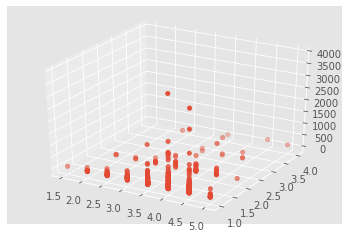

In [531]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = X_dessert.stars
ys = X_dessert.has_dessert
zs = X_dessert.review_count
ax.scatter(xs, ys, zs, )

Map 

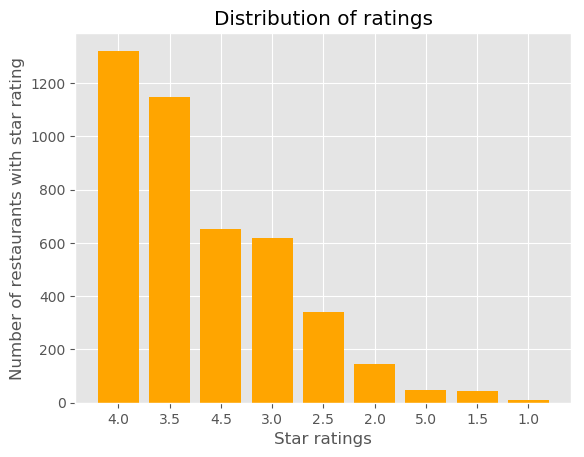

<Figure size 1200x800 with 0 Axes>

In [612]:
import collections
stars = clean_df.stars.value_counts().to_dict()

plt.bar(range(len(stars)), stars.values(), align='center', color = 'orange')
plt.xticks(range(len(stars.keys())), stars.keys())
plt.ylabel('Number of restaurants with star rating')
plt.xlabel('Star ratings')
plt.title('Distribution of ratings')
plt.figure(figsize=(12,8))
plt.show()

In [593]:
df_location.head(2)

,index,business_id,name,city,address,state,latitude,longitude,lat_long
0,9,1RHY4K3BD22FK7Cfftn8Mg,Marathon Diner,Pittsburgh,"Center Core - Food Court, Fl 3, Pittsburgh Int...",PA,40.496177,-80.246011,"(40.4961769456, -80.2460112364)"
1,11,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,6055 E Lake Mead Blvd,NV,36.195615,-115.040529,"(36.1956146, -115.0405289)"


In [707]:
# Create a map using the Map() function and the coordinates for JFK Airport
# tiles : 'CartoDB dark_matter' or 'Stamen Terrain'

import folium
def map_recommendations(name, num = 1000):
    df_loc = df_location.merge(find_closest(name.lower()), on='business_id')
    df_recommend  = df.iloc[1:num+1,:]
    
    start_lat = list(df_loc.iloc[:1,6])[0]
    start_long = list(df_loc.iloc[:1,7])[0]
    
    m = folium.Map(location=[start_lat, start_long],zoom_start=5,tiles = 'Stamen Terrain')

    
    for index, row in df_recommend.iterrows():

        popup_text = "Restaurant: {} "
        popup_text = popup_text.format(row['name'])

        folium.CircleMarker(location=(row['latitude'],
                                      row['longitude']),
                            popup = popup_text,
                            radius=2,
                            color='orange',
                            fill=True).add_to(m)
    return m

In [708]:
map_recommendations('marathon diner')